### MODELO DETERMINÍSTICO -- Python -- DATOS: IDEAM & NASA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time 

In [2]:
data = pd.read_excel("datos_ideam_nasa.xlsx")
data.head()

,DATE,GHI,TEMP
0,2015-01-01 00:00:00,0.000000,15.30
1,2015-01-01 01:00:00,1.127396,14.90
2,2015-01-01 02:00:00,0.000000,14.59
3,2015-01-01 03:00:00,0.000000,14.24
4,2015-01-01 04:00:00,1.127396,14.17


In [3]:
data['DATE'] = pd.to_datetime(data['DATE'])
irradiance = data["GHI"]
temperatura = data["TEMP"]
nr = 0.211
beta = 0.003
t_cNOCT = 44
t_aNOCT = 20
irradiance_NOCT = 800
T_r = 25
data["Efficiency"] = nr*(1-(0.9*beta*(irradiance/irradiance_NOCT)*(t_cNOCT-t_aNOCT))-beta*(temperatura-T_r))
data

,DATE,GHI,TEMP,Efficiency
0,2015-01-01 00:00:00,0.000000,15.30,0.217140
1,2015-01-01 01:00:00,1.127396,14.90,0.217374
2,2015-01-01 02:00:00,0.000000,14.59,0.217590
3,2015-01-01 03:00:00,0.000000,14.24,0.217811
4,2015-01-01 04:00:00,1.127396,14.17,0.217836
...,...,...,...,...
14954,2016-11-30 19:00:00,0.000000,16.02,0.216684
14955,2016-11-30 20:00:00,0.000000,15.91,0.216754
14956,2016-11-30 21:00:00,0.000000,15.72,0.216874
14957,2016-11-30 22:00:00,0.000000,15.51,0.217007


In [4]:
## Área del techo para el caso determinístico
area = 200
area_util = area*0.75
N_paneles = round(area_util/13.13,0)
N_paneles

11.0

In [5]:
### Generación de energía
### Tomando en cuenta: Eficiencia del inversor (96%) --> Pérdida por conversión: DC to AC 
data["Generacion"]  = N_paneles*(data["Efficiency"]-0.04)*2.2567285*data["GHI"]*1
data

,DATE,GHI,TEMP,Efficiency,Generacion
0,2015-01-01 00:00:00,0.000000,15.30,0.217140,0.000000
1,2015-01-01 01:00:00,1.127396,14.90,0.217374,4.964076
2,2015-01-01 02:00:00,0.000000,14.59,0.217590,0.000000
3,2015-01-01 03:00:00,0.000000,14.24,0.217811,0.000000
4,2015-01-01 04:00:00,1.127396,14.17,0.217836,4.977008
...,...,...,...,...,...
14954,2016-11-30 19:00:00,0.000000,16.02,0.216684,0.000000
14955,2016-11-30 20:00:00,0.000000,15.91,0.216754,0.000000
14956,2016-11-30 21:00:00,0.000000,15.72,0.216874,0.000000
14957,2016-11-30 22:00:00,0.000000,15.51,0.217007,0.000000


In [6]:
data["Generacion"][13]

3093.5554883468567

In [7]:
df = data
df['Year_Month'] = df['DATE'].dt.to_period('M')
monthly_generation = df.groupby('Year_Month')['Generacion'].sum().reset_index()
df = df.merge(monthly_generation, on='Year_Month', suffixes=('', '_Monthly_Sum'))
df['Monthly_Generation_Sum'] = df['Generacion_Monthly_Sum'].where(df['DATE'].dt.to_period('M').duplicated(keep='first') == False)
df.drop(columns=['Generacion_Monthly_Sum'], inplace=True)

In [8]:
monthly_df = df[['Year_Month', 'Monthly_Generation_Sum']].dropna().drop_duplicates()
monthly_df.reset_index(drop=True, inplace=True)
monthly_df["Generation_kWh"] = monthly_df["Monthly_Generation_Sum"]/1000
monthly_df
monthly_df['Generation_kWh'][7] = monthly_df['Generation_kWh'][19]

C:\Users\Admin\AppData\Local\Temp\ipykernel_3248\858420107.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  monthly_df['Generation_kWh'][7] = monthly_df['Generation_kWh'][19]
C:\Users\Admin\AppData\Local\Temp\ipykernel_3248\858420107.py:5

In [9]:
monthly_df

,Year_Month,Monthly_Generation_Sum,Generation_kWh
0,2015-01,592921.766802,592.921767
1,2015-02,534042.619973,534.042620
2,2015-03,528979.103211,528.979103
3,2015-04,517475.391277,517.475391
4,2015-05,613978.091096,613.978091
5,2015-06,656322.705530,656.322706
6,2015-07,665752.698353,665.752698
7,2015-09,278729.857764,571.791145
8,2015-10,524893.840322,524.893840
9,2015-11,479343.953780,479.343954


### Cálculo de flujos de caja y VPN (anual)

In [10]:
import numpy as np
import numpy_financial as npf
monthly_generation_kWh_extended = np.tile(monthly_df["Generation_kWh"].values, 15 // (len(monthly_df) // 12))

consumption_data = [283, 205, 261, 230, 217, 277, 235, 377, 376, 359, 292, 293] * 15
price_of_kWh = 961.53
sale_price_of_kWh = 622.31
opex_yearly = 253450
capex_cop = 29967106
tributary_benefit_factor = 0.5
wacc = 0.10
p_kwh_increment = 0.052
inflation_rate = 0.05

monthly_generation_kWh_extended = monthly_generation_kWh_extended[:len(consumption_data)]

surplus_kWh = np.array(monthly_generation_kWh_extended) - np.array(consumption_data)
savings_cop = np.where(surplus_kWh > 0, np.array(consumption_data) * price_of_kWh, np.array(monthly_generation_kWh_extended) * price_of_kWh)
revenue_cop = np.where(surplus_kWh > 0, surplus_kWh * sale_price_of_kWh, 0)

cash_flow_before_taxes = savings_cop + revenue_cop 
valor_utv = 47065
if capex_cop < 275*valor_utv:
    cert_upme = 1.2*valor_utv
elif capex_cop > 275*valor_utv and capex_cop < 826 * valor_utv:
    cert_upme = 3.4*valor_utv

years = 15
annual_cash_flows = []
for year in range(years):
    adjusted_opex = opex_yearly
    cash_flow_year = np.sum(cash_flow_before_taxes[year * 12:(year + 1) * 12]) - adjusted_opex
    if year == 0:
        cash_flow_year += - (capex_cop + cert_upme) 
    if year == 1:
        tributary_benefit = capex_cop * tributary_benefit_factor
        cash_flow_year += tributary_benefit  
    price_of_kWh = price_of_kWh * (1 + p_kwh_increment)
    sale_price_of_kWh = sale_price_of_kWh * (1 + p_kwh_increment)
    annual_cash_flows.append(cash_flow_year)

npv_deterministic = npf.npv(wacc, annual_cash_flows)
print(f"VPN DEL PROYECTO: {round(npv_deterministic,2)} COP")


cash_flow_data = pd.DataFrame({
    'Year': np.arange(1, years + 1),
    'Annual Cash Flow (COP)': annual_cash_flows
})
print(cash_flow_data)

VPN DEL PROYECTO: 26770916.64 COP
    Year  Annual Cash Flow (COP)
0      1           -2.495288e+07
1      2            2.014899e+07
2      3            5.174376e+06
3      4            5.115205e+06
4      5            5.154530e+06
5      6            5.274352e+06
6      7            5.197724e+06
7      8            5.210774e+06
8      9            5.220157e+06
9     10            5.043152e+06
10    11            5.198623e+06
11    12            5.174243e+06
12    13            5.165440e+06
13    14            5.174376e+06
14    15            5.115205e+06


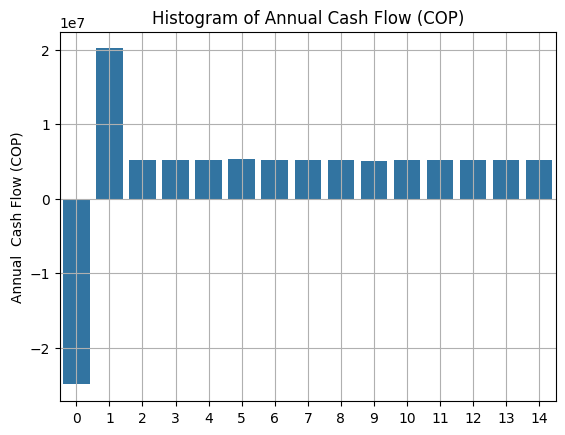

In [11]:
sns.barplot(cash_flow_data["Annual Cash Flow (COP)"])
plt.xlabel('')
plt.ylabel('Annual  Cash Flow (COP)')
plt.title('Histogram of Annual Cash Flow (COP)')
plt.grid(True)
plt.show()

Gráfica de flujos de caja

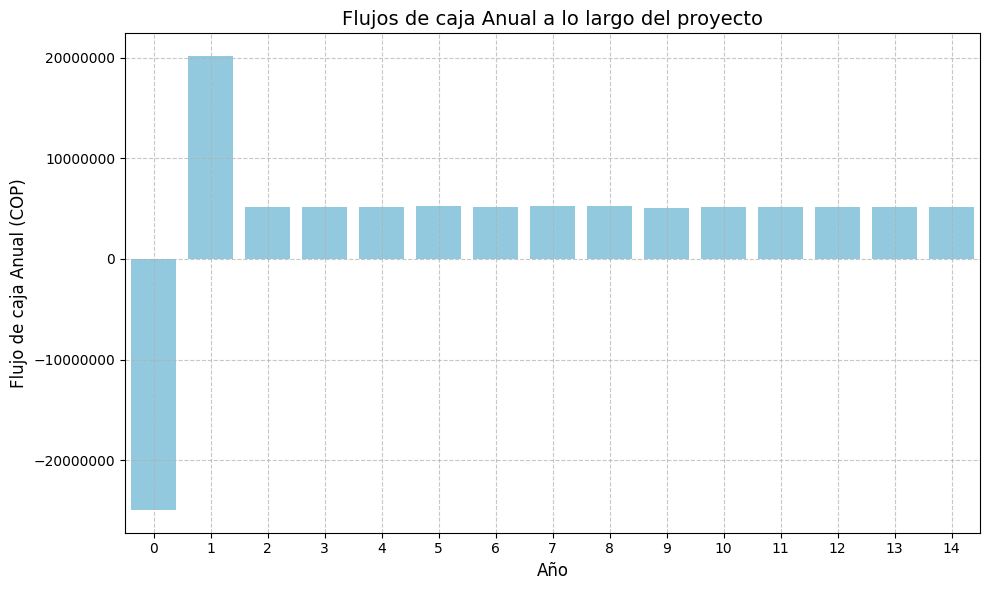

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gráfico mejorado del flujo de caja anual
plt.figure(figsize=(10, 6))

# Gráfico de barras usando seaborn con paleta de colores personalizada
sns.barplot(x=cash_flow_data.index, y=cash_flow_data["Annual Cash Flow (COP)"], color='skyblue', edgecolor='none')

# Ajustar etiquetas y formato de la gráfica
plt.xlabel('Año', fontsize=12)
plt.ylabel('Flujo de caja Anual (COP)', fontsize=12)
plt.title('Flujos de caja Anual a lo largo del proyecto', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Formatear el eje y para mostrar los valores en millones de COP
plt.ticklabel_format(style='plain', axis='y')

# Mostrar la gráfica
plt.tight_layout()
plt.show()


Gráfica generación mensual de energía eléctrica por hora

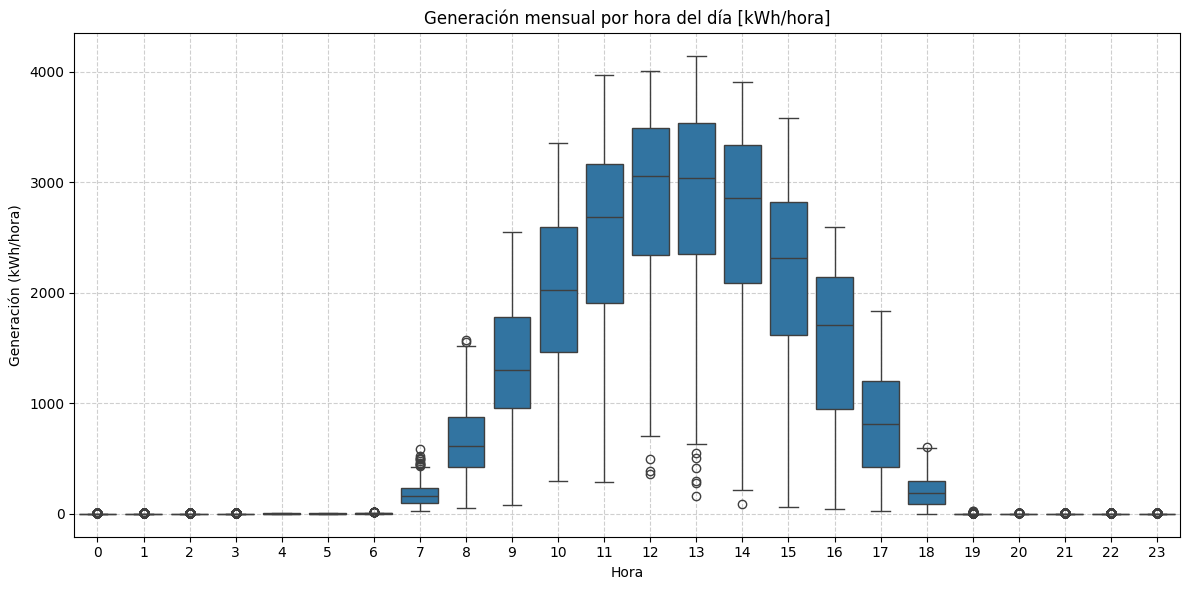

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns


data['DATE'] = pd.to_datetime(data['DATE'])
data['Hour'] = data['DATE'].dt.hour
plt.figure(figsize=(12, 6))
sns.boxplot(x='Hour', y='Generacion', data=data)
plt.xlabel('Hora')
plt.ylabel('Generación (kWh/hora)')
plt.title('Generación mensual por hora del día [kWh/hora]')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

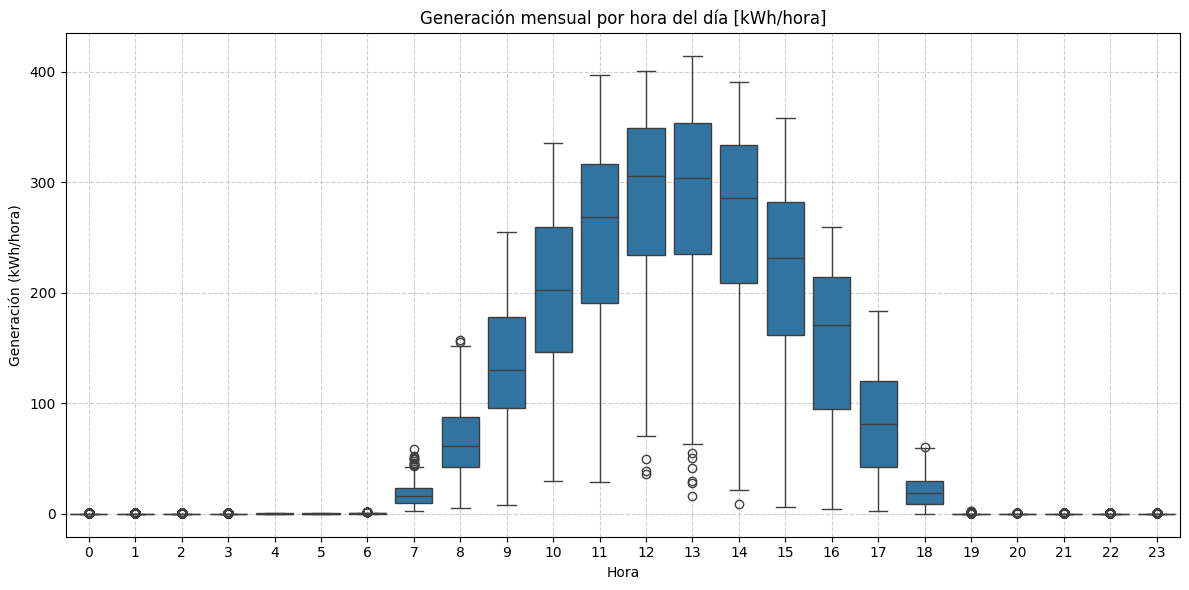

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data['DATE'] = pd.to_datetime(data['DATE'])
data['Hour'] = data['DATE'].dt.hour
data['Generacion_scaled'] = data['Generacion'] / 10

plt.figure(figsize=(12, 6))
sns.boxplot(x='Hour', y='Generacion_scaled', data=data)
plt.xlabel('Hora')
plt.ylabel('Generación (kWh/hora)')
plt.title('Generación mensual por hora del día [kWh/hora]')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Gráfica de generación por temporada

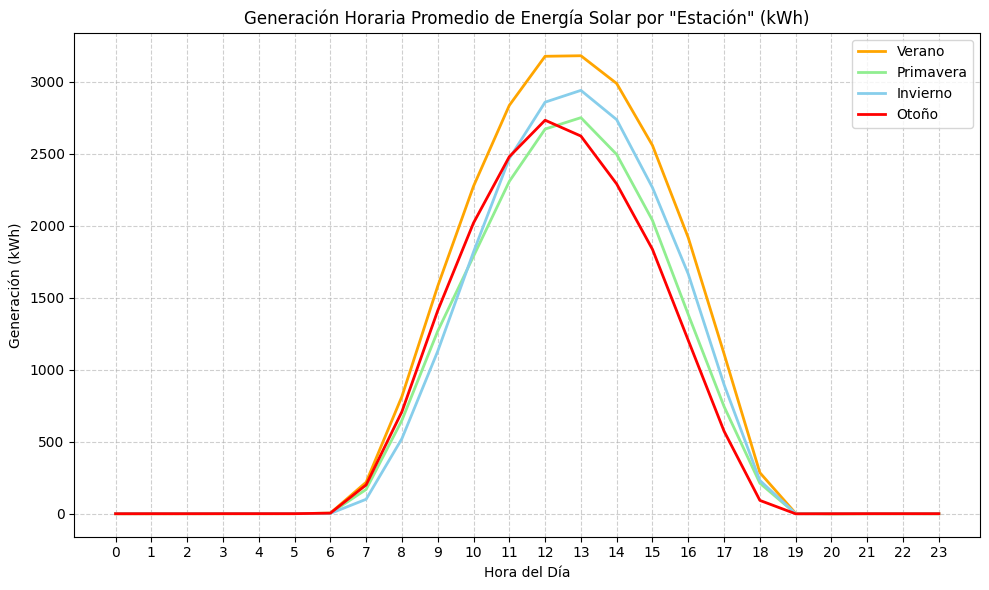

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def assign_season(month):
    if month in [12, 1, 2]:
        return 'Invierno'
    elif month in [3, 4, 5]:
        return 'Primavera'
    elif month in [6, 7, 8]:
        return 'Verano'
    elif month in [9, 10, 11]:
        return 'Otoño'
data['Season'] = data['DATE'].dt.month.apply(assign_season)
data['Hour'] = data['DATE'].dt.hour
seasonal_hourly_generation = data.groupby(['Season', 'Hour'])['Generacion'].mean().reset_index()
season_colors = {
    'Verano': 'orange',
    'Primavera': 'lightgreen',
    'Invierno': 'skyblue',
    'Otoño': 'red'
}
plt.figure(figsize=(10, 6))
for season, color in season_colors.items():
    season_data = seasonal_hourly_generation[seasonal_hourly_generation['Season'] == season]
    plt.plot(season_data['Hour'], season_data['Generacion'], label=season, color=color, linewidth=2)
plt.title('Generación Horaria Promedio de Energía Solar por "Estación" (kWh)')
plt.xlabel('Hora del Día')
plt.ylabel('Generación (kWh)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(np.arange(0, 24, step=1))
plt.legend()
plt.tight_layout()
plt.show()

Capacity factor

In [15]:
energia_generada_total = data["Generacion"].sum() / 1000  # Energía total generada en kWh
# Capacidad instalada del sistema (en kW)
potencia_nominal_panel = 0.575  # Cada panel tiene una capacidad nominal de 575 W (0.575 kW) Los de Ambiente Solar
capacidad_instalada = N_paneles * potencia_nominal_panel  # Capacidad instalada total en kW
horas_del_periodo = 8760  #  un año completo (24 horas * 365 días)
factor_capacidad = (energia_generada_total / (capacidad_instalada * horas_del_periodo)) * 100  # En porcentaje
print(f"El Factor de Capacidad del sistema es: {factor_capacidad:.2f}%")


El Factor de Capacidad del sistema es: 22.19%


In [16]:
#Calcular la IRR (TIR)
irr_deterministic = npf.irr([-(capex_cop + cert_upme)] + annual_cash_flows)
print(f"TIR DEL PROYECTO: {round(irr_deterministic * 100, 2)}%")
print("TIR de Excel: 9.25%")

TIR DEL PROYECTO: 7.67%
TIR de Excel: 9.25%
